In [612]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# 2. Разделение датасета и препроцесинг
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.impute import SimpleImputer, KNNImputer

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

### Описания полей датасета по недвижимости

* Id - идентификационный номер квартиры,

* DistrictId - идентификационный номер района,

* Rooms - количество комнат,

* Square - площадь,

* LifeSquare - жилая площадь,

* KitchenSquare - площадь кухни,

* Floor - этаж,

* HouseFloor - количество этажей в доме,

* HouseYear - год постройки дома,

* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности,

* Social_1, Social_2, Social_3 - социальные показатели местности,

* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья,

* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров,

* Price - цена квартиры.

In [613]:
matplotlib.rcParams.update({'font.size': 14}) 

In [614]:
DATASET_PATH = r'C:\Users\user\Desktop\DataScience\Libraries_for_DS\project\data\train.csv'

In [615]:
df = pd.read_csv(DATASET_PATH, sep=',')

In [616]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [617]:
df = df.drop(['Id'], axis=1) # удалим встроеный id
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int64  
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  object 
 10  Ecology_3      10000 non-null  object 
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  object 
 18  Price  

## Оптимизация памяти

In [618]:
def reduce_mem_usage(df):
    """ проходим по всем колонкам дата фрейма и оптимезируем тип данных в соответствии с диапазоном данных.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [619]:
reduce_mem_usage(df)

Memory usage of dataframe is 1.45 MB
Memory usage after optimization is: 0.47 MB
Decreased by 67.7%


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.937500
1,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.437500
2,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.906250
3,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.234375
4,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,32,2.0,50.401787,30.476204,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.312500
9996,18,1.0,41.521545,20.539215,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.296875
9997,27,1.0,47.939007,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.812500
9998,75,2.0,43.602562,33.840149,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.343750


##  Проверка Дубликатов


In [620]:
print(f'Количество дублей {df[df.duplicated()].shape[0]} в нашем сете из {df.shape[0]}')
df.drop_duplicates(keep='first',inplace=True) # оставяем первый вариант
print(f'После удаления количество записей в наборе данных - {df.shape[0]}')

Количество дублей 0 в нашем сете из 10000
После удаления количество записей в наборе данных - 10000


## Замена пропусков

In [621]:
print(f'Процент пропусков в признаках\n{df.isnull().sum()*100/df.shape[0]}')

Процент пропусков в признаках
DistrictId        0.00
Rooms             0.00
Square            0.00
LifeSquare       21.13
KitchenSquare     0.00
Floor             0.00
HouseFloor        0.00
HouseYear         0.00
Ecology_1         0.00
Ecology_2         0.00
Ecology_3         0.00
Social_1          0.00
Social_2          0.00
Social_3          0.00
Healthcare_1     47.98
Helthcare_2       0.00
Shops_1           0.00
Shops_2           0.00
Price             0.00
dtype: float64


LifeSquare расчитаем из из того что LifeSquare находится в интервале от 0.5 до 0.7 по отношению к Square            
возьмем середину - 0.6
Healthcare_1- содержит слишком много пропусков отбросим признак

In [622]:
df['LifeSquare'].fillna(df['Square']*0.6, inplace=True)
df.drop(['Healthcare_1'], axis=1, inplace=True)

In [623]:
print(f'Процент пропусков в признаках после замены значений по медиане\n{df.isnull().sum()*100/df.shape[0]}')

Процент пропусков в признаках после замены значений по медиане
DistrictId       0.0
Rooms            0.0
Square           0.0
LifeSquare       0.0
KitchenSquare    0.0
Floor            0.0
HouseFloor       0.0
HouseYear        0.0
Ecology_1        0.0
Ecology_2        0.0
Ecology_3        0.0
Social_1         0.0
Social_2         0.0
Social_3         0.0
Helthcare_2      0.0
Shops_1          0.0
Shops_2          0.0
Price            0.0
dtype: float64


## Визуализация целевой переменой

In [624]:
target_mean = round(df['Price'].mean(), 2)
target_median = df['Price'].median()
target_mode = df['Price'].mode()[0]
target_bins = df['Price'] // 10000 * 10000
target_adjusted_mode = target_bins.mode()[0]

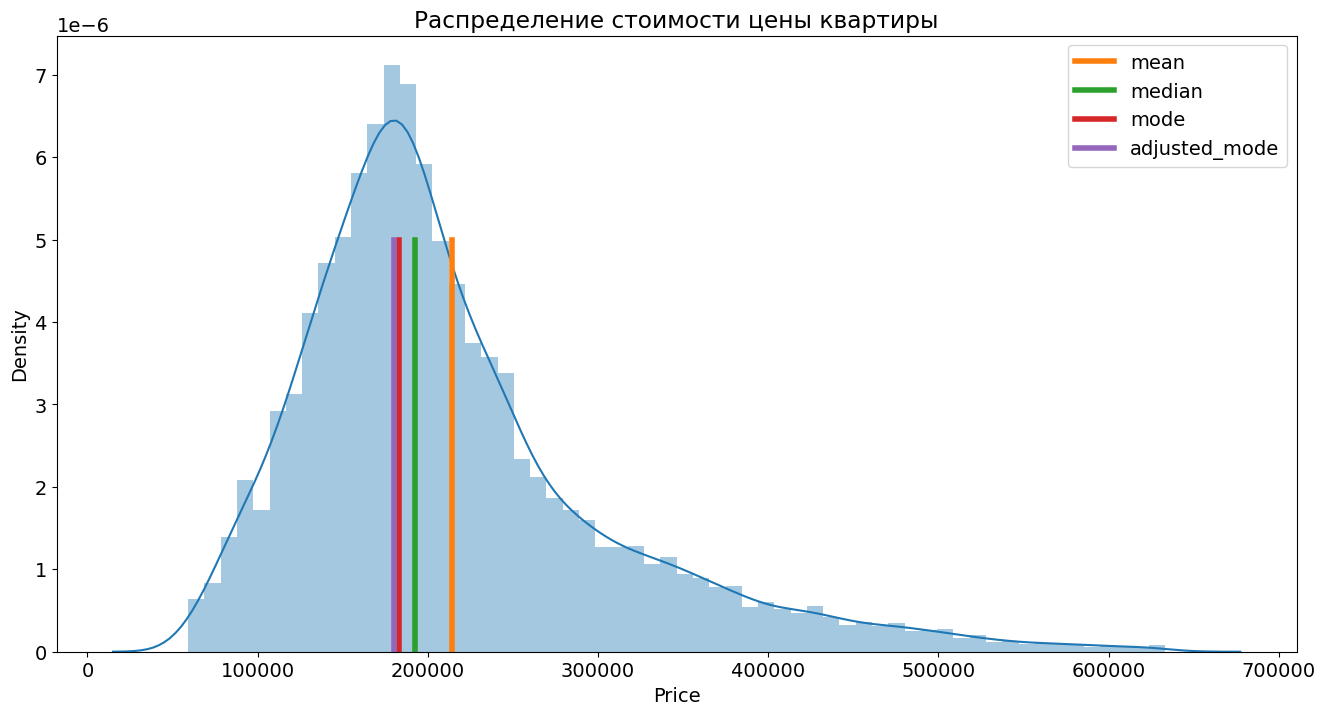

In [625]:
plt.figure(figsize = (16, 8))

sns.distplot(df['Price'], bins=60)

y = np.linspace(0, 0.000005, 100)
plt.plot([target_mean] * 100, y, label='mean', linewidth=4)
plt.plot([target_median] * 100, y, label='median', linewidth=4)
plt.plot([target_mode] * 100, y, label='mode', linewidth=4)
plt.plot([target_adjusted_mode]*100, y, label='adjusted_mode', linestyle='-', linewidth=4)

plt.title('Распределение стоимости цены квартиры')
plt.legend()
plt.show()

Распределение стоимости недвижимисти имет вид отличный от нормального с хвостом вправо

## Боксплоты для числовых признаков и очистка от вбросов

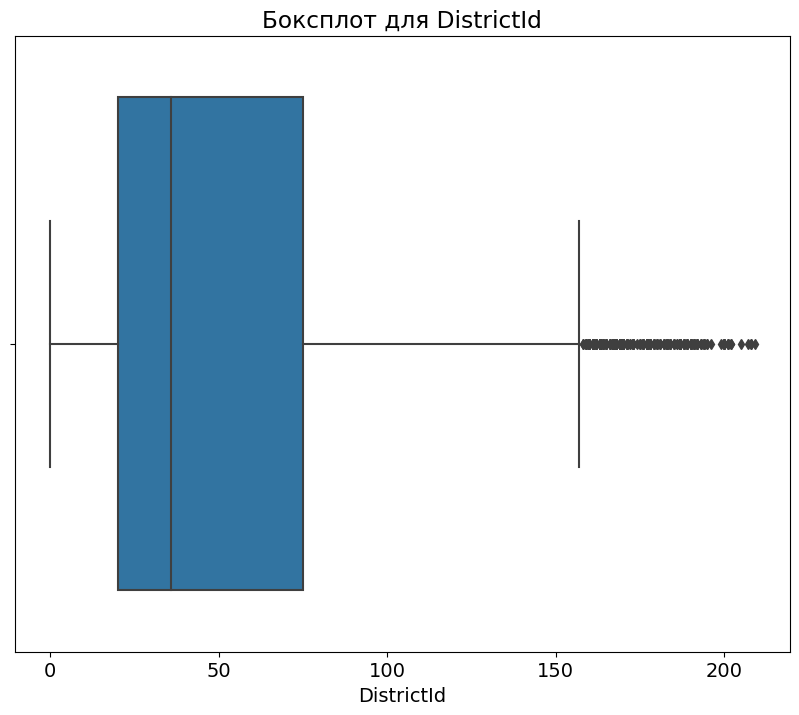

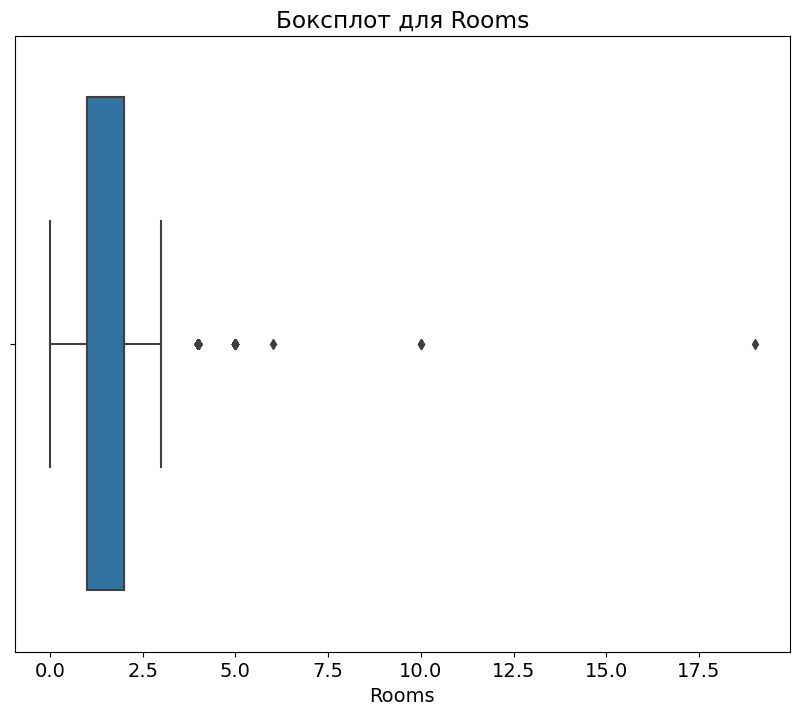

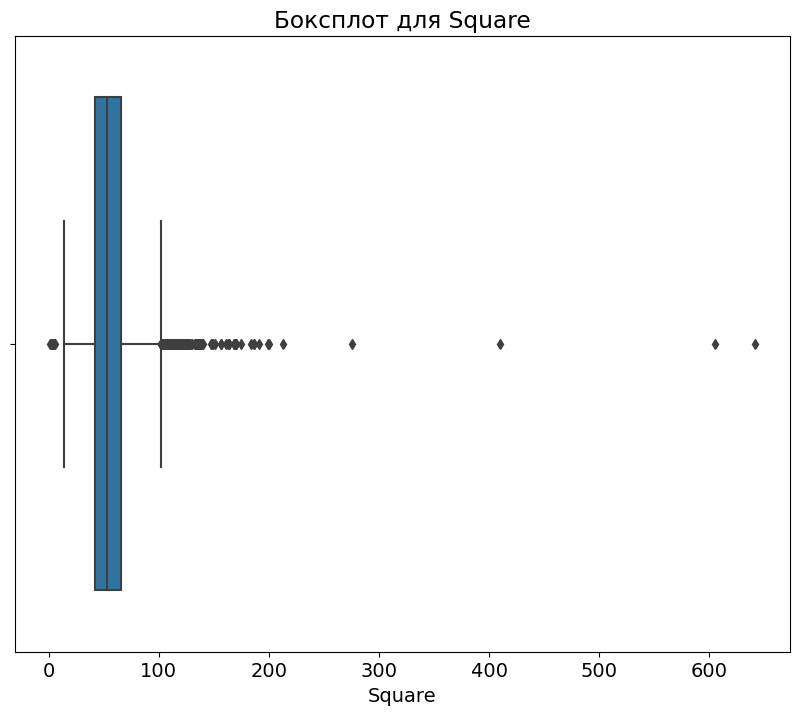

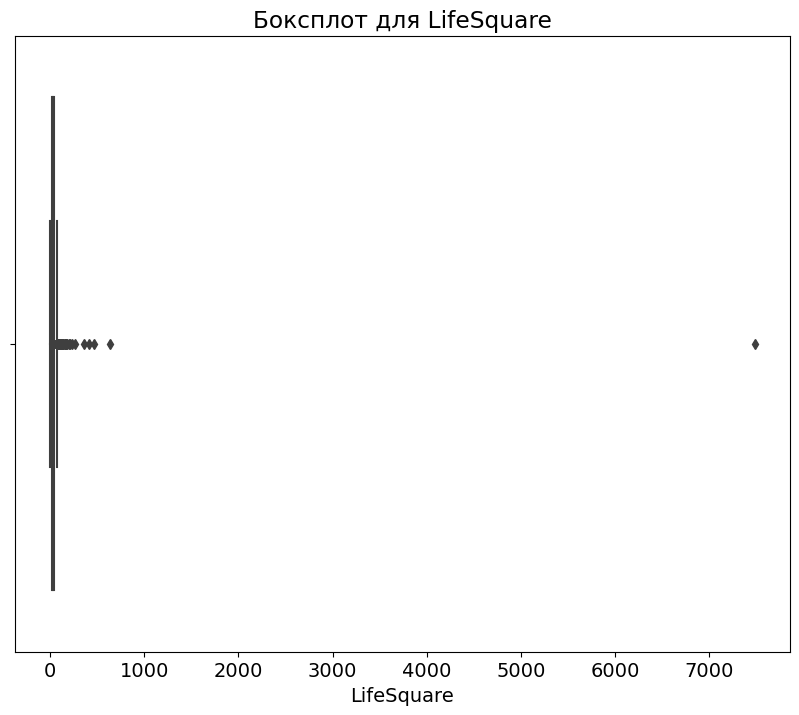

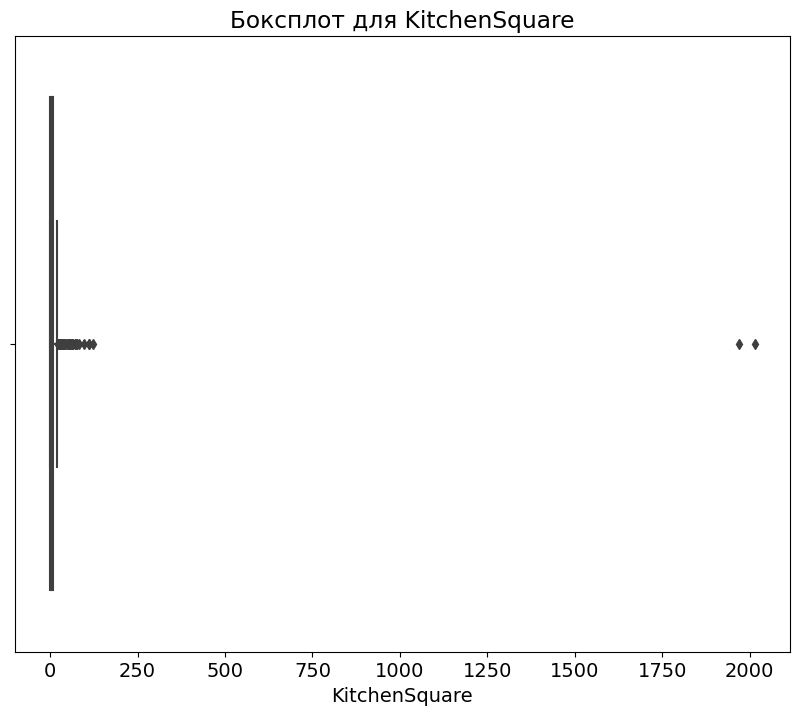

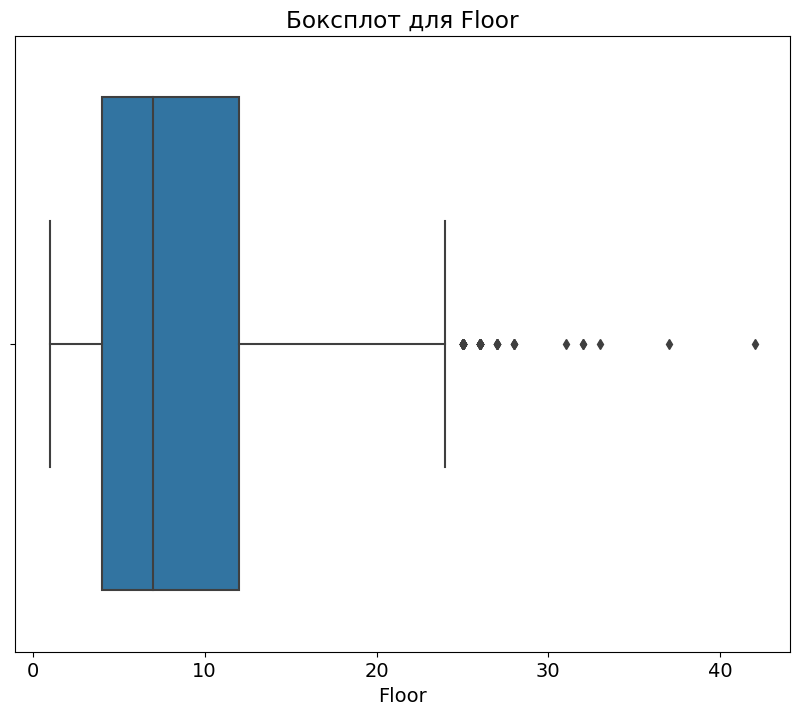

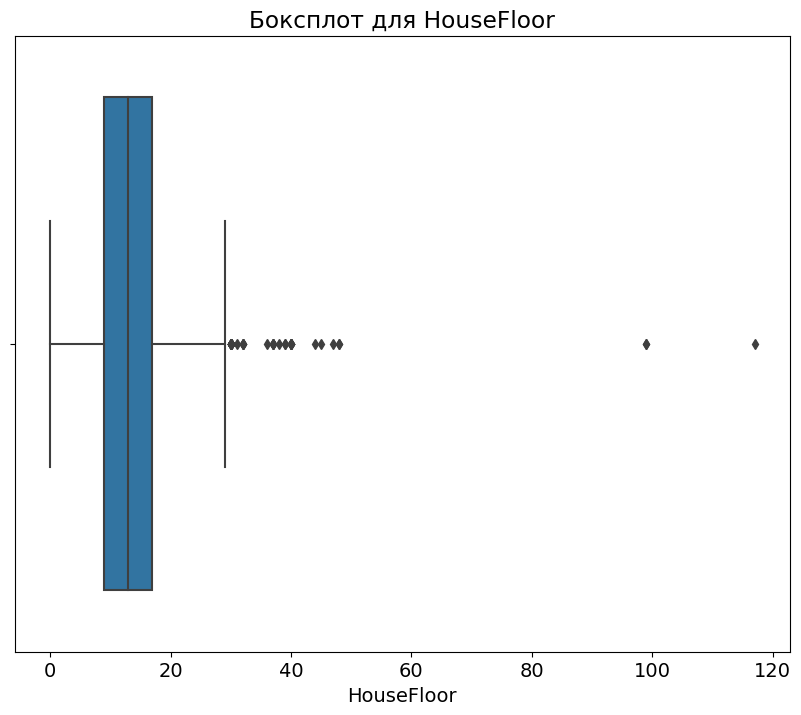

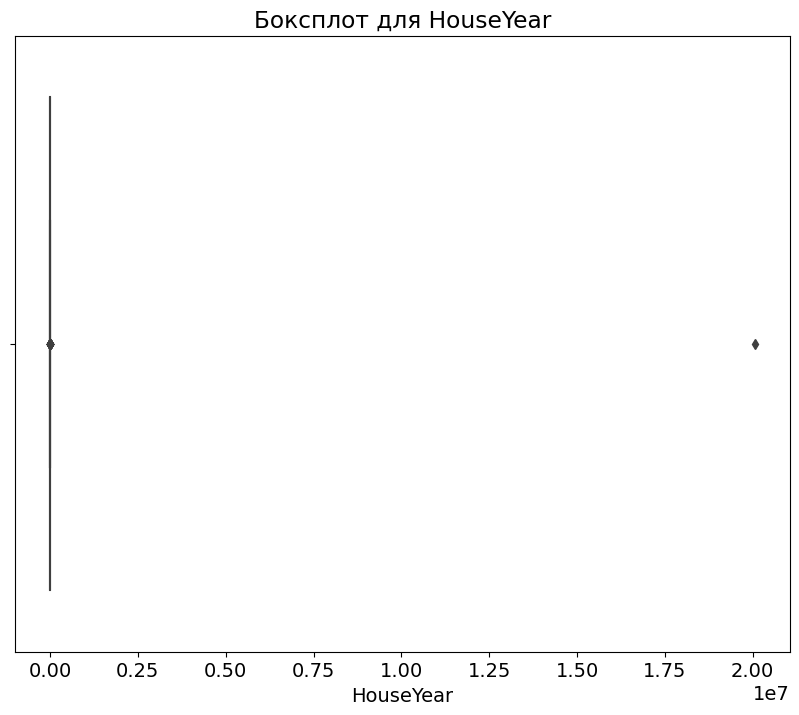

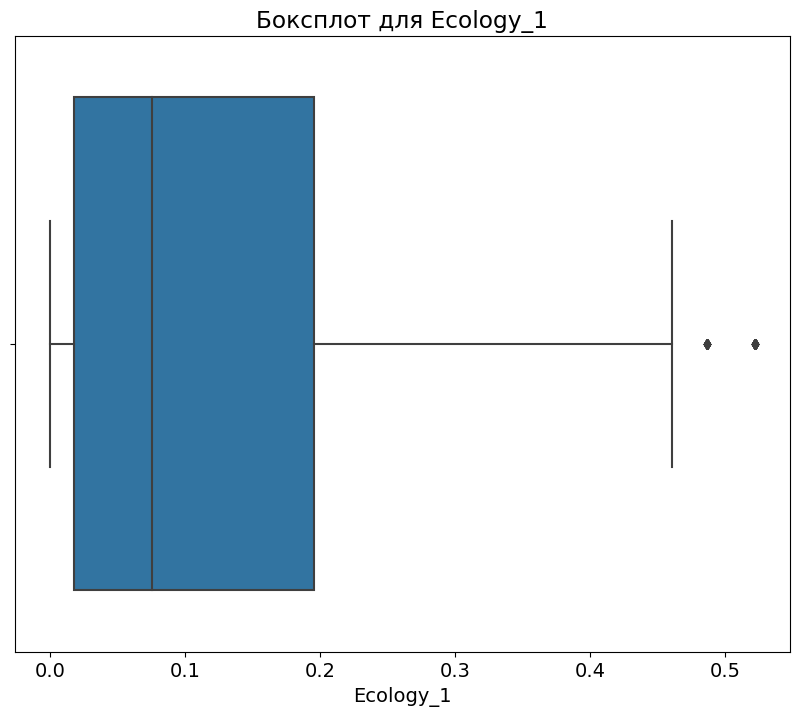

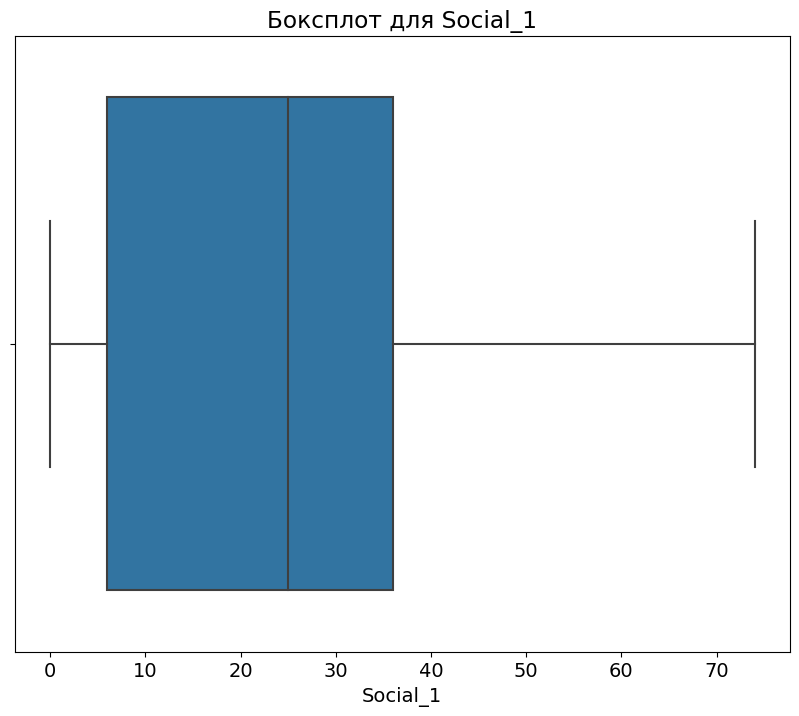

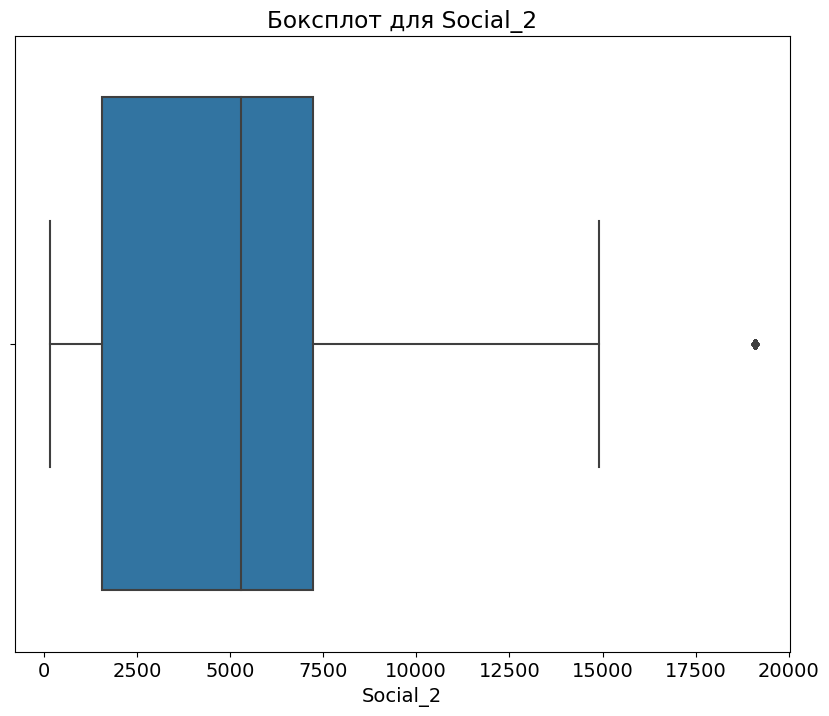

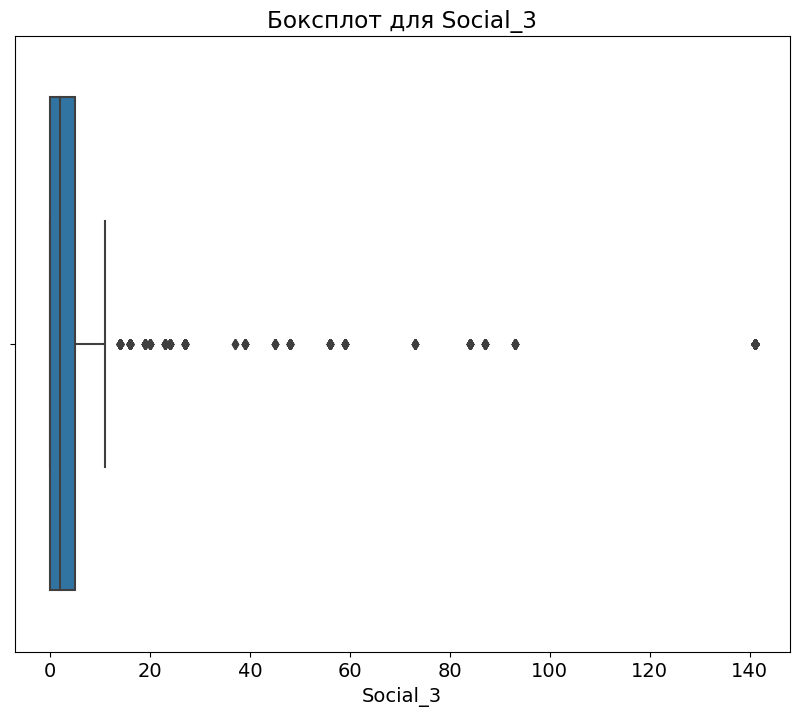

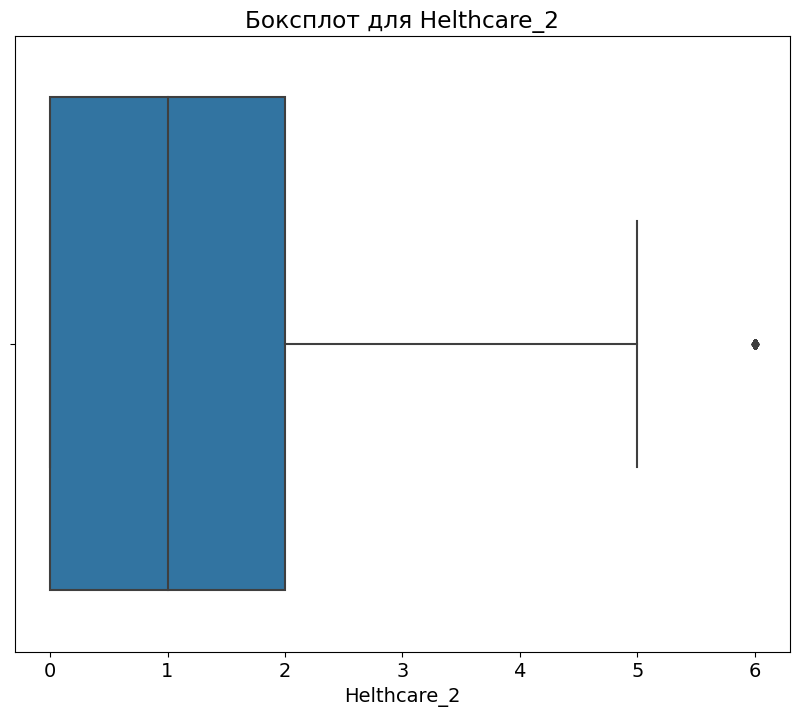

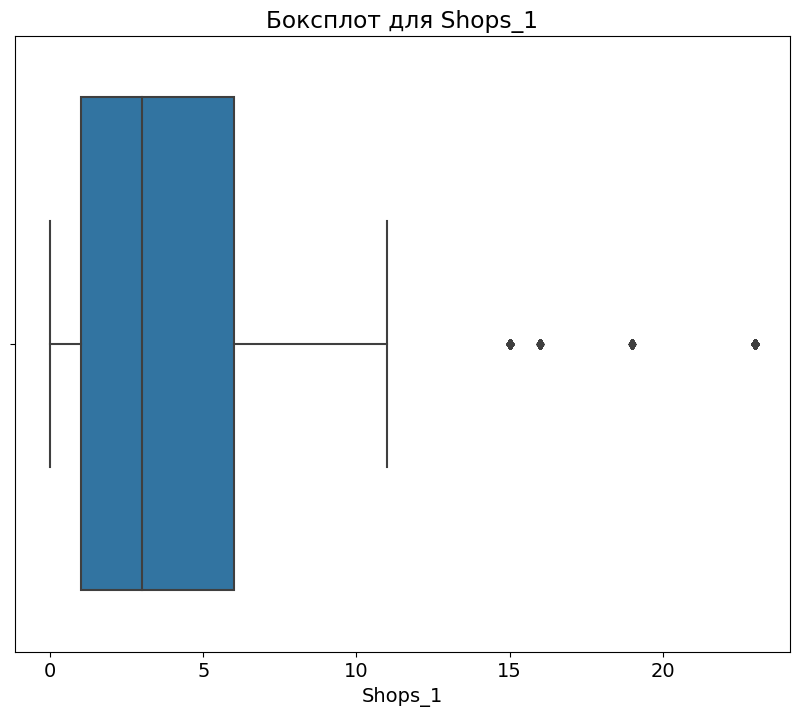

In [626]:
def num_boxplot(df):
    df_num = df.select_dtypes(exclude=['category', 'object'])
    for el in df_num.columns[:-1]:
        plt.figure(figsize=(10, 8))
        sns.boxplot(df_num[el], whis=1.5)
        plt.title("Боксплот для " + str(el))
num_boxplot(df)

Наблюдаются вбросы в следующих признаках - **DistrictId, Rooms, Square, lifeSquare, KitchenSquare, Floor, HouseFloor, HouseFloor, Ecology_1, Social_1, Social_2, Social_3, Healthcare_1, Helthcare_2, Shops_1, HouseYear**
В 1ю очередь избавимся от самых существеных Square, lifeSquare, KitchenSquare, HouseYear

Явные вбросы позднее заменим на медианное значением подмножества состоящего из квартир со схожей ценой +- 5%.  
**Явные вбросы:**
* Square 7м2 и LifeSquare 7м2 (самая маленькая квартира в Москве имеет площадь 9 квадратных метров возьмем с запасом) 
* HouseYear не более 2022 и не менее 1920 - год застройки Москвы
* KitchenSquare не более 30 м2 
* LifeSquare верхний предел 150 м2
* Square верхний предел 150 м2
* Этаж 100 и 120 возможен для элитного жилья. 
* Так же ограничем количество комнат до 7

### Функция для замены крайне выдающихся значений признаков

In [627]:
def replace_data_out_of_range(df, Feature, Target, high=False, low=False, p_low=0.95, p_high=1.05):   
    """ Функция обрабатывает вбросы которые ниже или выше предельного значения и заменяет их медианой,
    взятой из подмножества по целевой переменой +-5%.
    Предельное значение можно выбрать по боксплотам или же исходя из логики признака.
    """
    if high:
        wrong_sq = list(df.loc[(df[Feature] > high)][Target]) # значение ЦП у вброса
        wrong_f = list(df.loc[(df[Feature] > high)][Feature]) # значение вброса признака
        median_list = []
        for el in wrong_sq:
            upper = el*1.05
            lower = el*0.95
            temp_df = df.loc[(df[Target] > lower) & (df[Target] < upper)] # подмножество df содержащие ЦП вбросового значения, 
            #и значения находящиеся в диапазоне +- 5% к этой цене
            median = temp_df[Feature].median() # можно и средним заменить тут сильной разнецы не будет
            median_list.append(median)
        median_dict = dict(zip(wrong_f, median_list))# создаем словарь из значения вброса и медианного занчения
        df = df.replace({Feature:median_dict})
        
    if low:
        wrong_sq = list(df.loc[(df[Feature] < low)][Target])
        wrong_f = list(df.loc[(df[Feature] < low)][Feature])
        median_list = []
        for el in wrong_sq:
            upper = el*1.05
            lower = el*0.95
            temp_df = df.loc[(df[Target] > lower) & (df[Target] < upper)]
            median = temp_df[Feature].median()
            median_list.append(median)
        median_dict = dict(zip(wrong_f, median_list))
        df = df.replace({Feature:median_dict})
    
    return df

In [628]:
df = replace_data_out_of_range(df=df, Feature='Square', Target='Price', low=9, high=150)
df = replace_data_out_of_range(df=df, Feature='LifeSquare', Target='Price', low=9, high=150)
df = replace_data_out_of_range(df=df, Feature='HouseYear', Target='Price', low=1920, high=2022)
df = replace_data_out_of_range(df=df, Feature='Rooms', Target='Price', high=7)
df = replace_data_out_of_range(df=df, Feature='KitchenSquare', Target='Price', high=30)

#### Обработка DistrictId 
(Количество округов 142 (125 районов и 21 поселения = 142))

In [629]:
df = df.loc[df['DistrictId']<142]

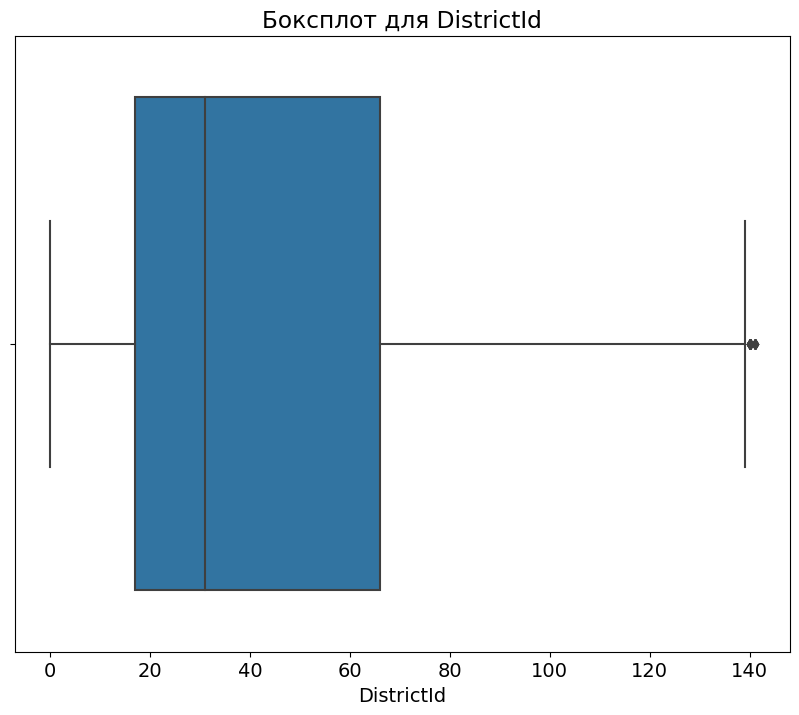

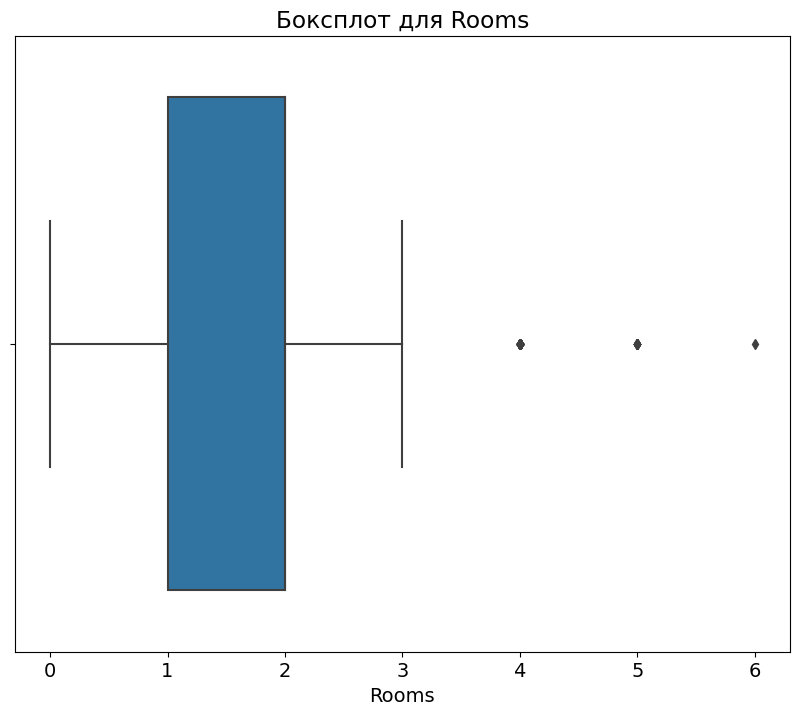

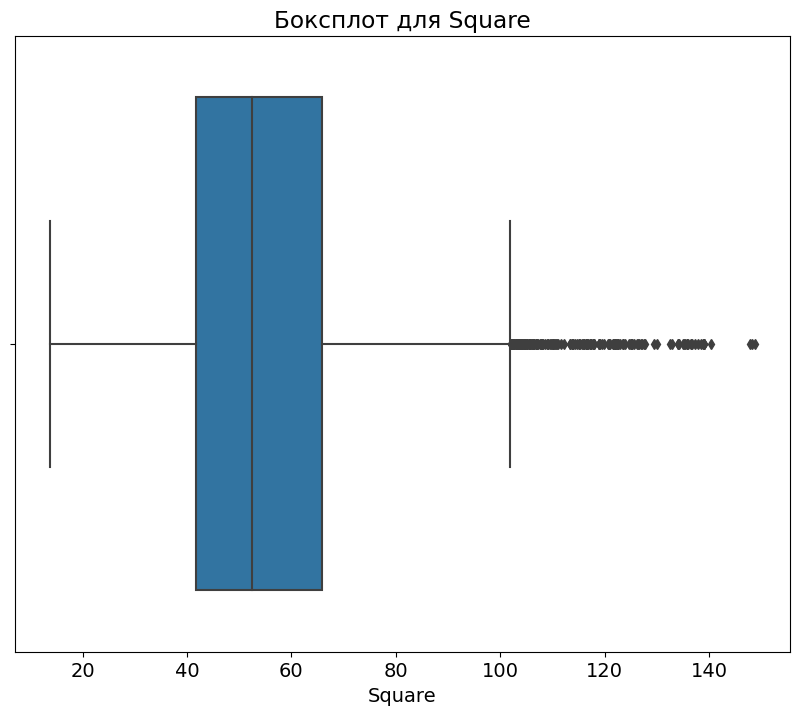

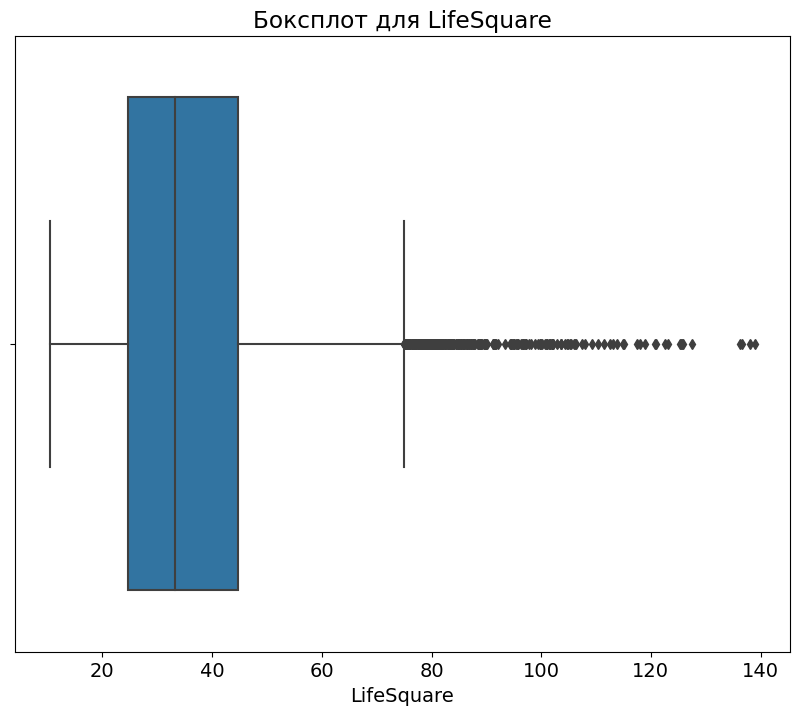

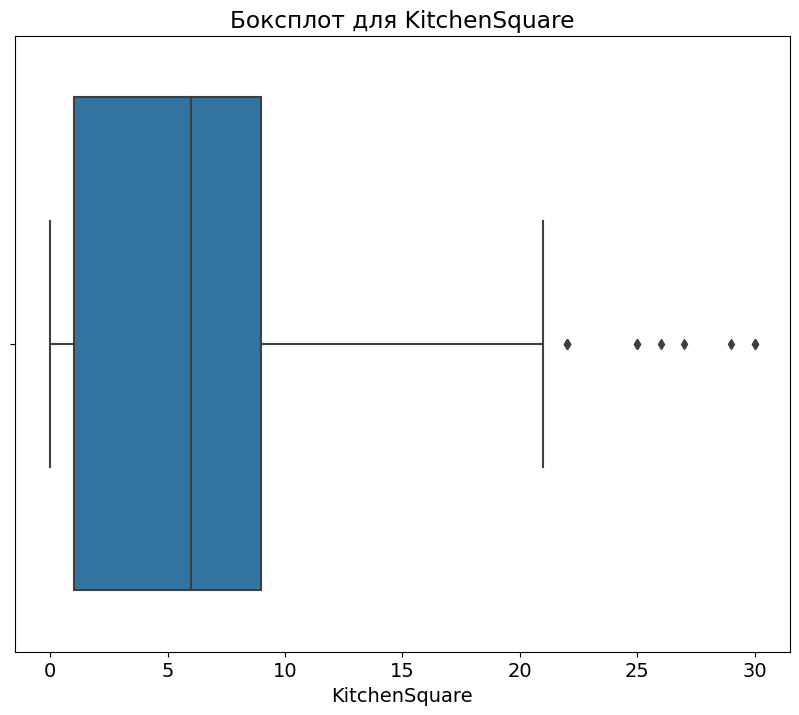

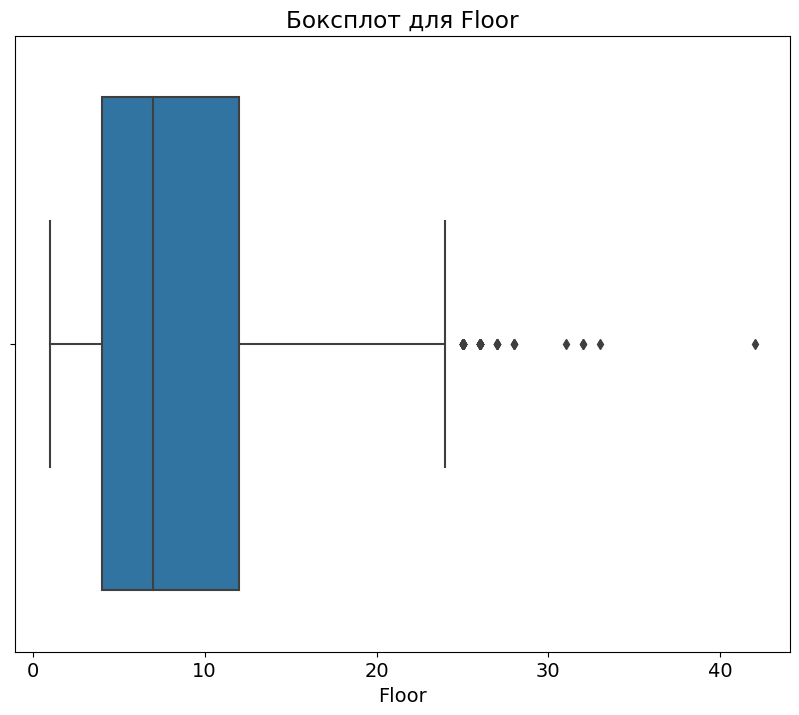

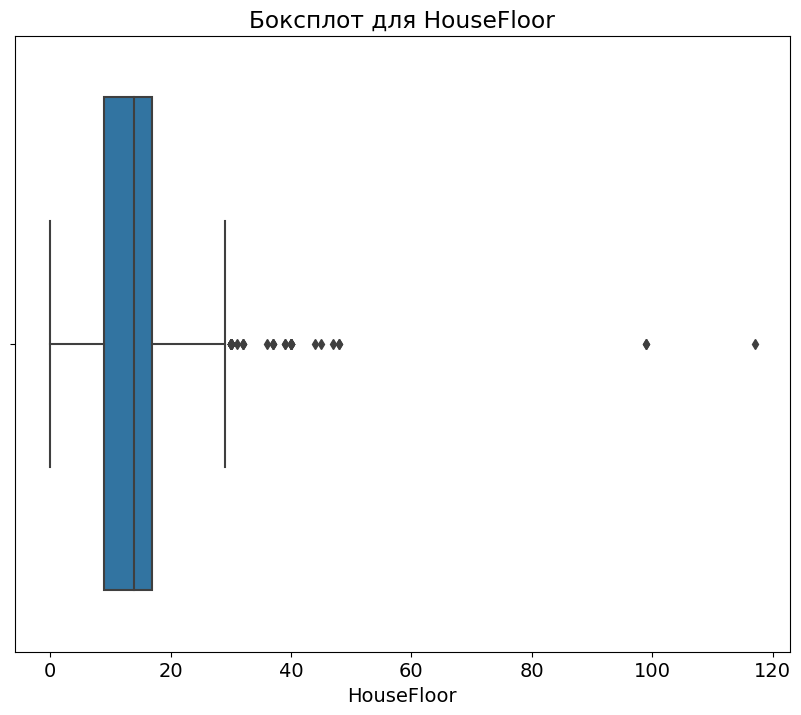

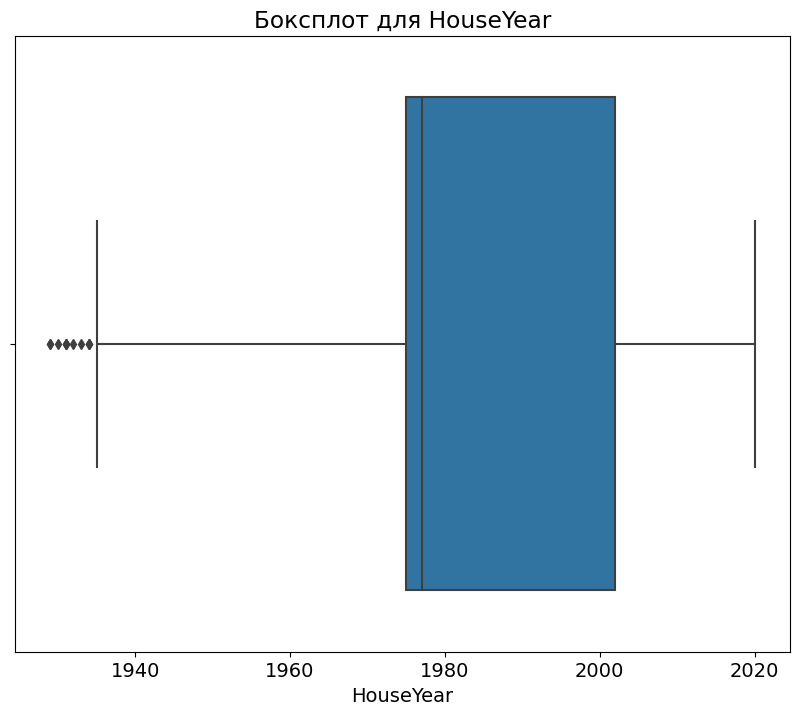

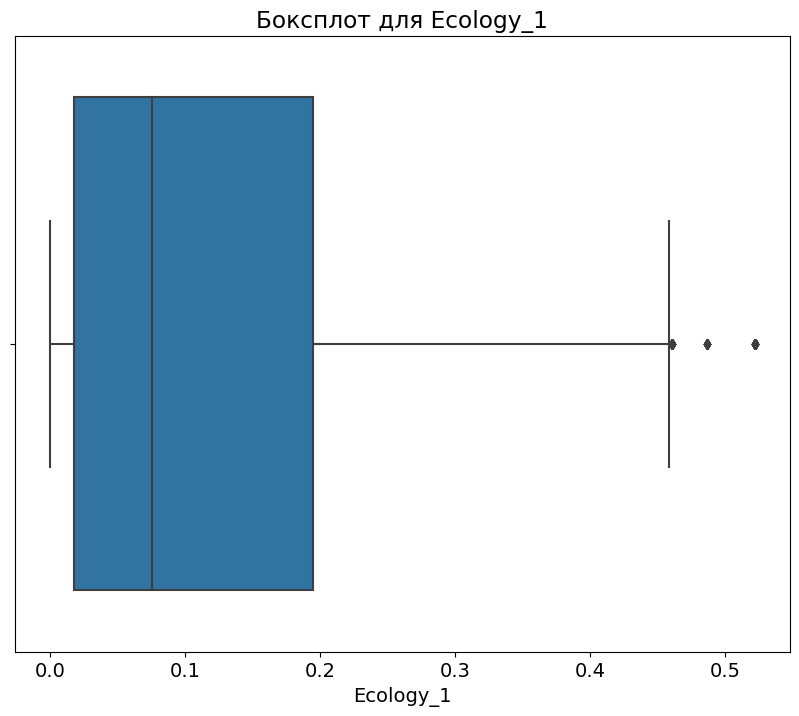

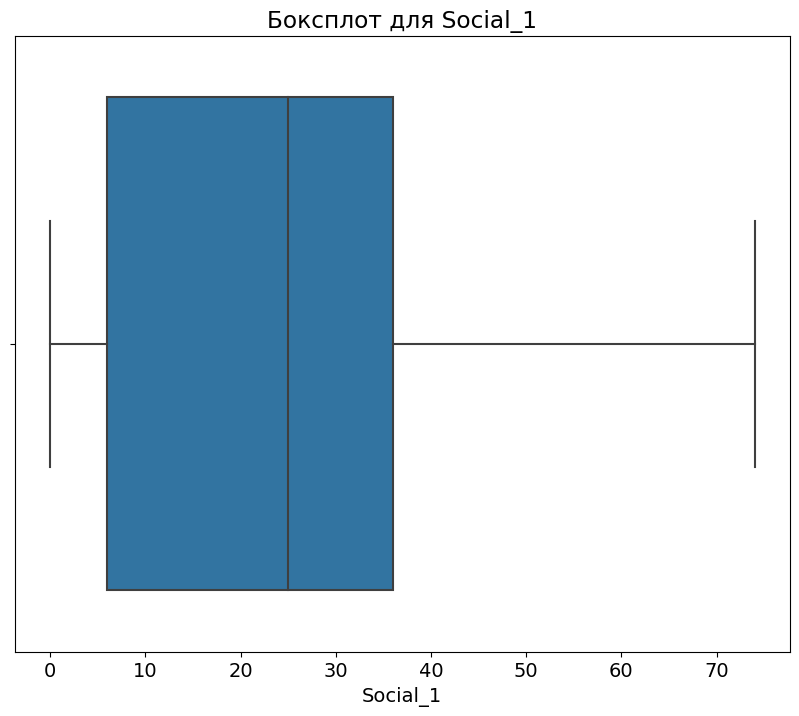

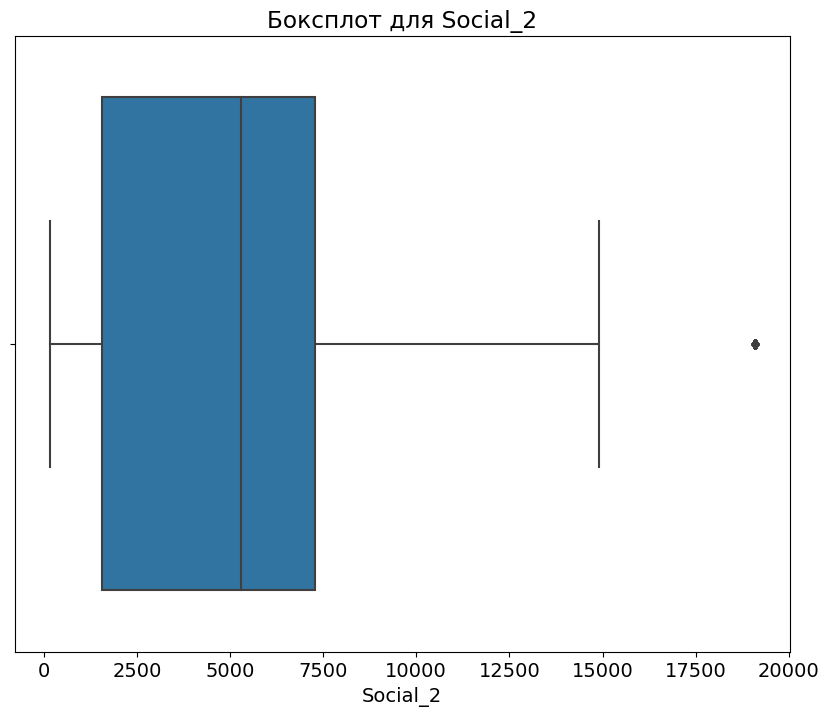

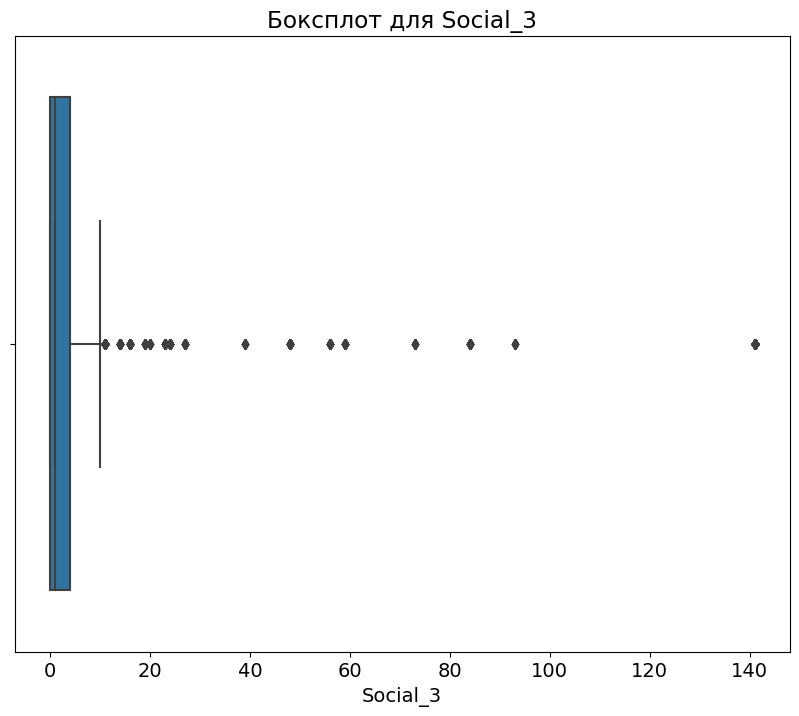

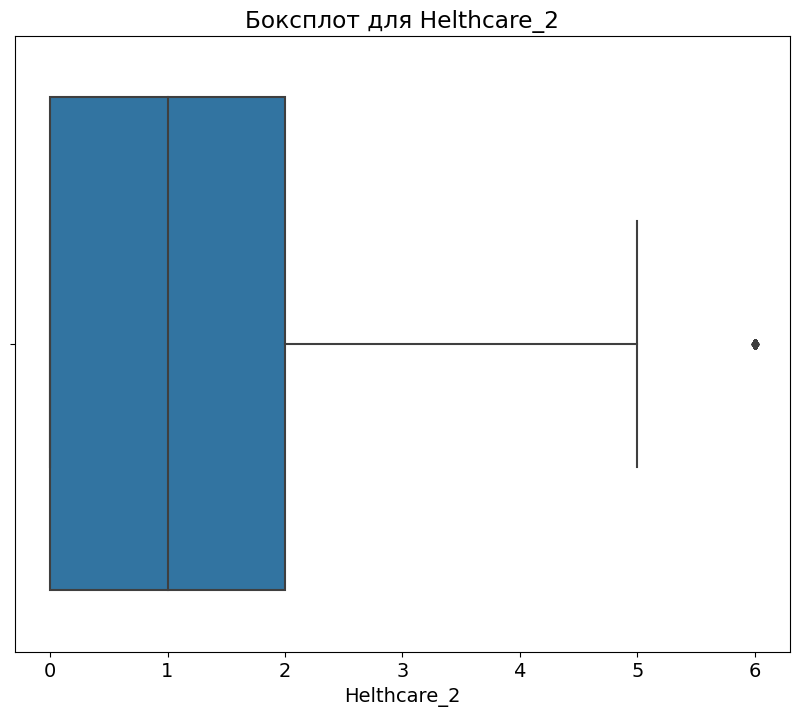

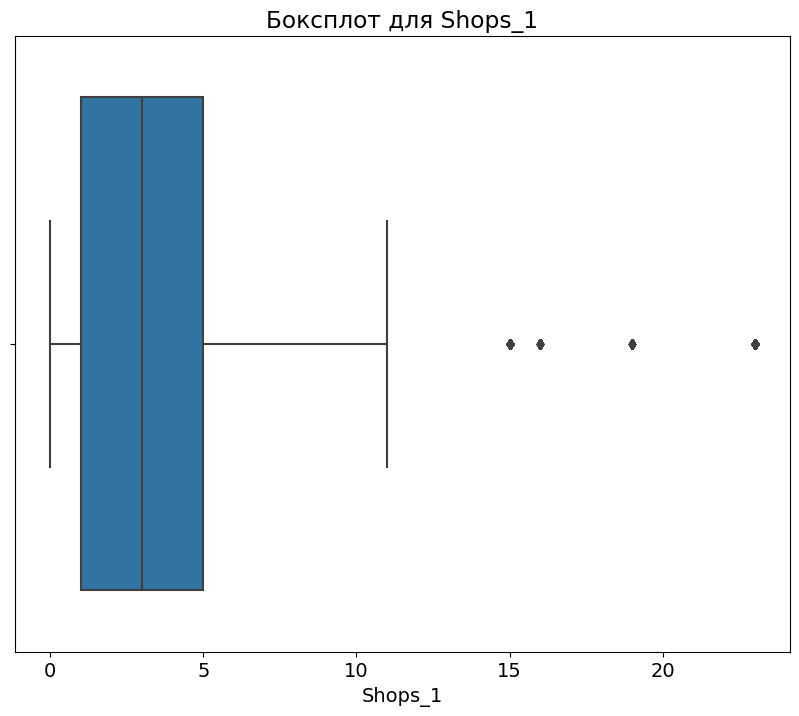

In [630]:
num_boxplot(df)

## Заметная значимость по шкале Чеддока - при коэффициенте корреляции |0.5| и выше


Коэффициент корреляции 0.57


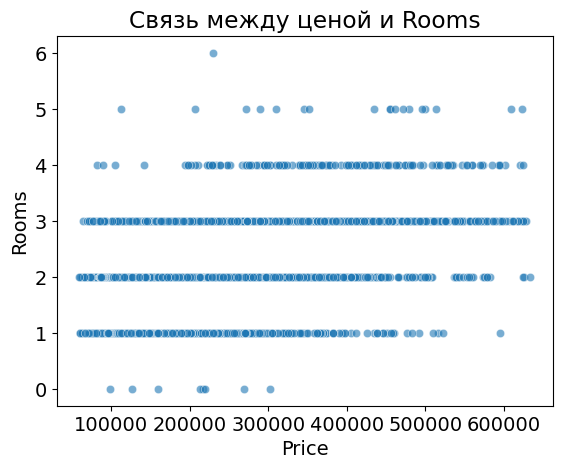

Коэффициент корреляции 0.6


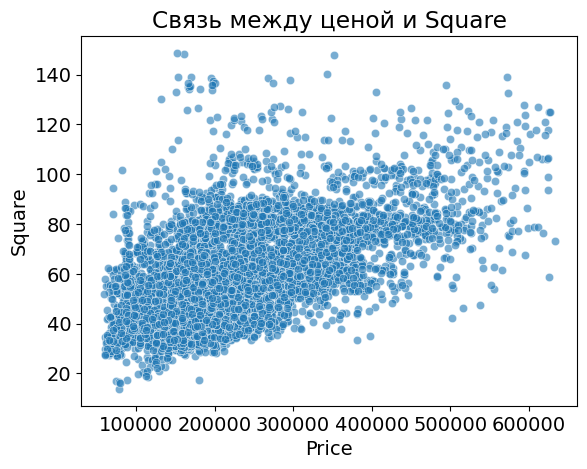

In [631]:
ched = 0.5

for i in df_num.columns[:-1]:
    c_corr = df_num[i].corr(df_num.Price)
    if abs(c_corr) >= ched:
        sns.scatterplot(x="Price", y=i, data=df_num, alpha=0.6)
        print("Коэффициент корреляции " + str(abs(round(c_corr,2))))
        plt.title("Связь между ценой и " + str(i))
        plt.show()

## Добавление признаков

### Признаки связаные с первым и последним этажем

In [632]:
df['first_flor'] = df['Floor']==1
df['lsast_flor'] = df['Floor']==df['HouseFloor']

### Добавим признак размер региона


In [633]:
district_size = df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
df = df.merge(district_size, on='DistrictId', how='left')

### Добавим признак Медианной цены по району
Признак расчитывается исходя из индентификатора района, площади и количества комнат

In [634]:
med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})
df = df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
cor_matrix = df.corr()
sorted_corr = cor_matrix['Price'].sort_values(ascending = False)

### Расмотрим вклад признаков в уравнение регресии 
(на основе кореляции сцелевой переменой)

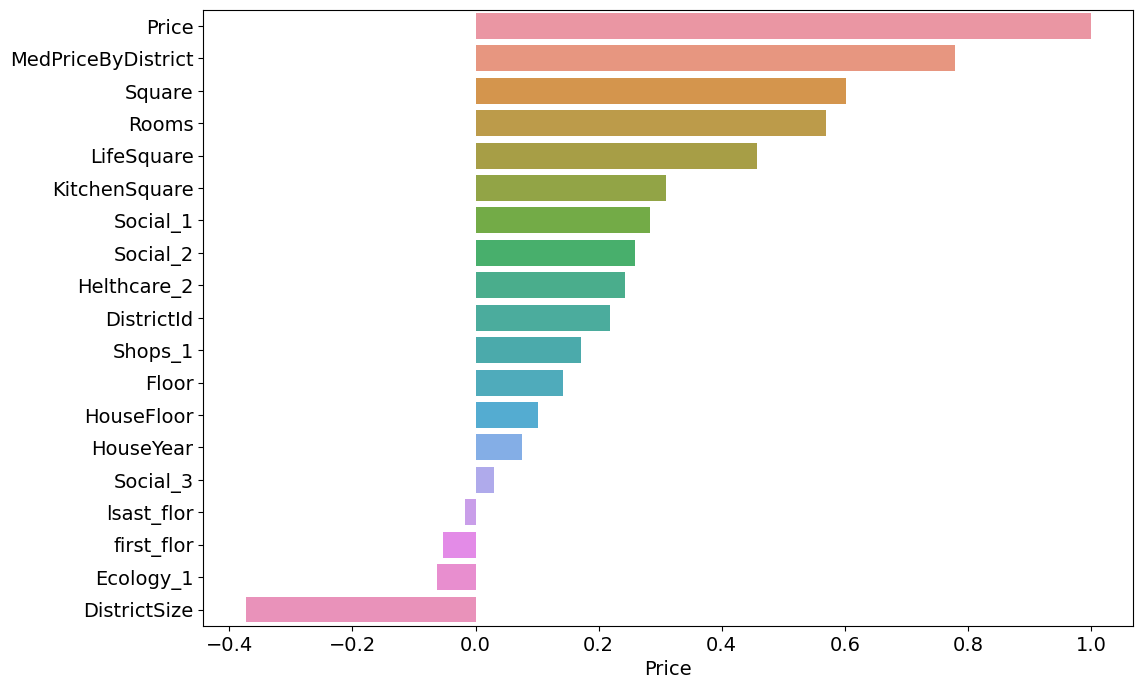

In [635]:
plt.figure(figsize=(12, 8))
sns.barplot(x=sorted_corr, y=sorted_corr.index);

Добавленая признака MedPriceByDistrict  вносит  ощутимый вклад в стоимость квартиры.  
Позже проверим влияние признаков после стандартизации (необходимо что бы все признаки имели равные возможности внести вклад в уравнение прямой) так же отрицательную кореляцию наблюдаем при добавлении DistrictSize         

## Матрица корреляций

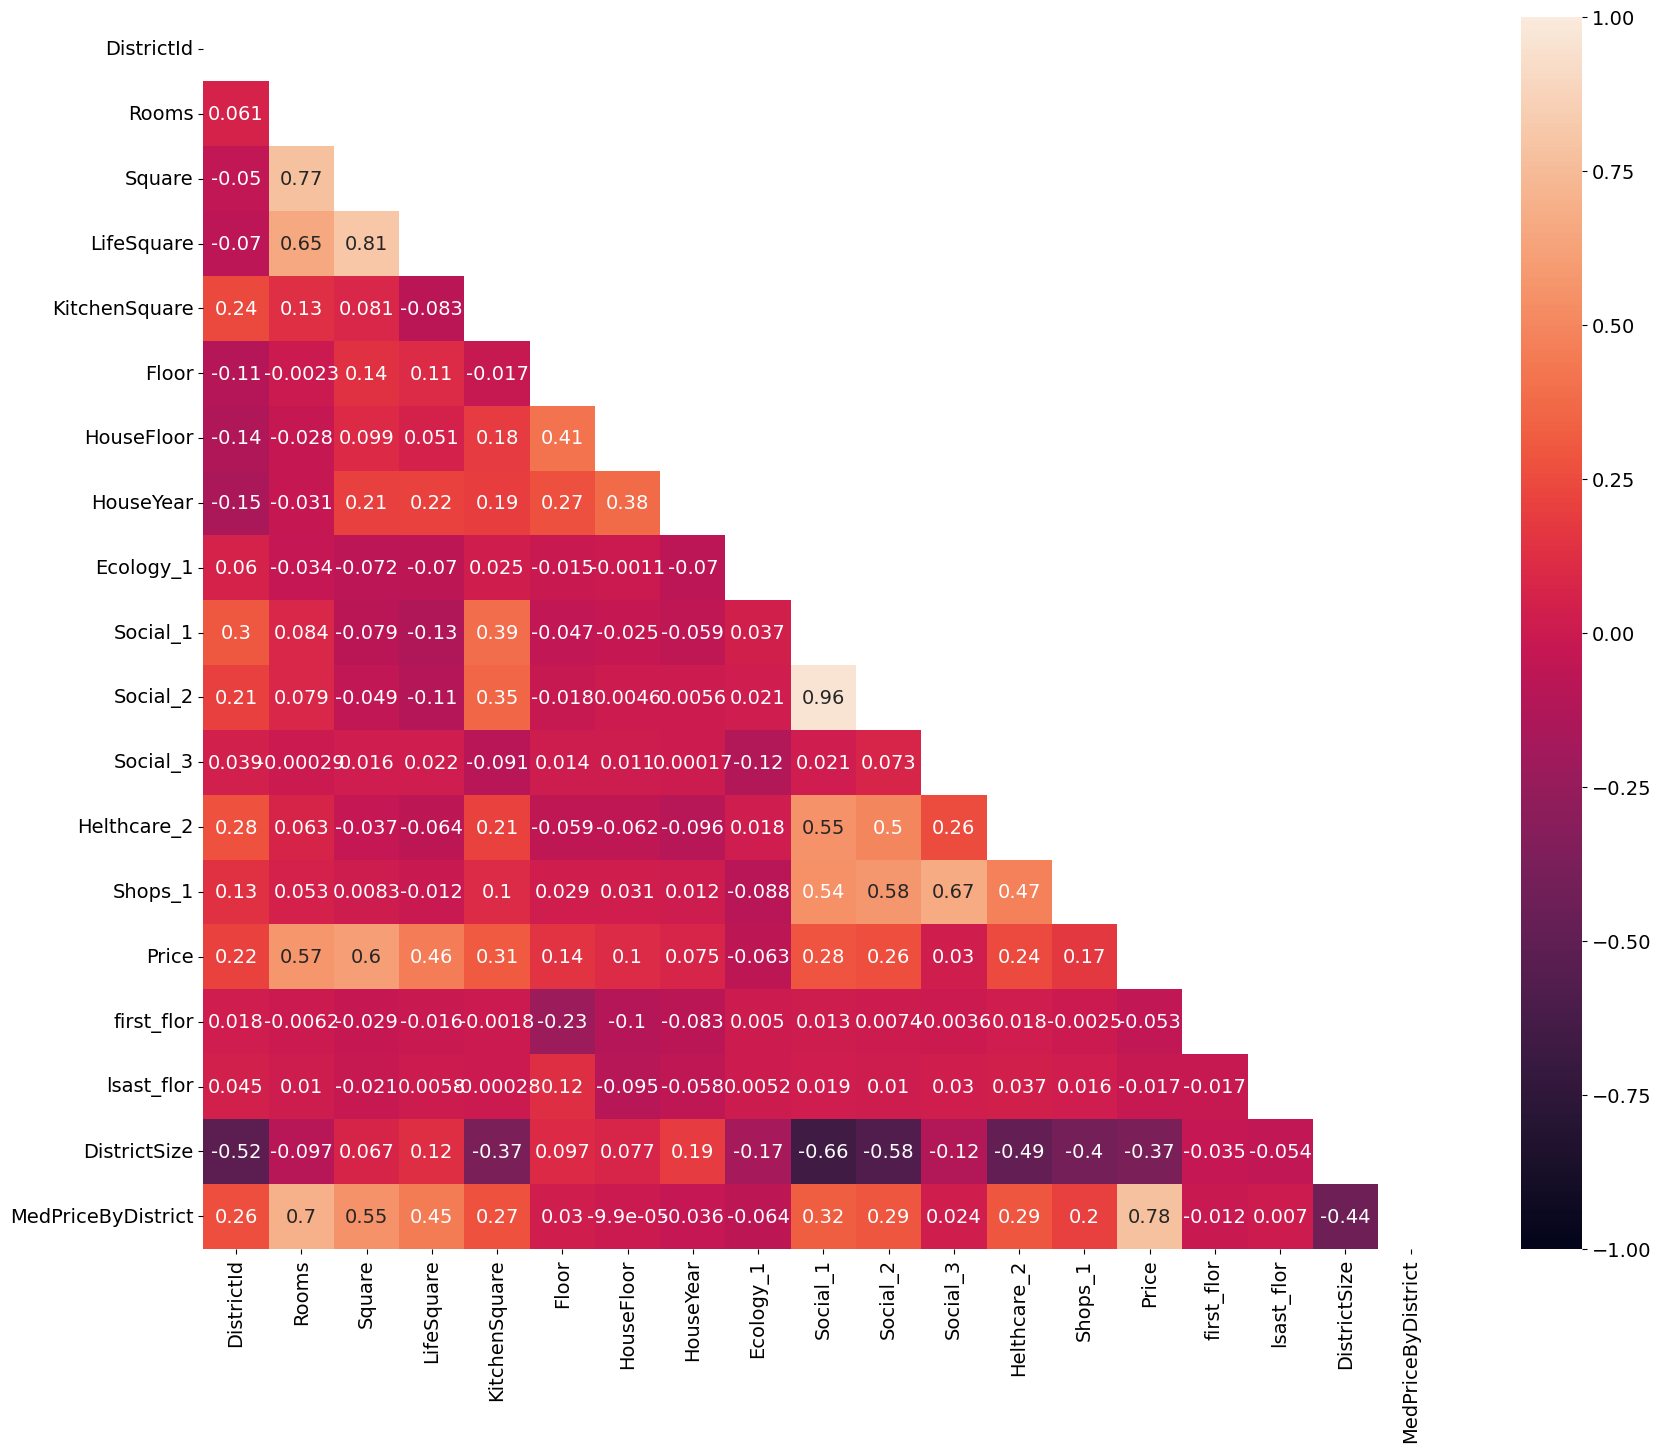

In [636]:
plt.figure(figsize=(20, 16))
mask = np.triu(df.corr())
sns.heatmap(df.corr(), center=0, annot=True, mask = mask, vmax=1, vmin=-1, cmap='rocket');

#### Сильной кореляция (более 0.7 и около 0.7) наблюдается между признаками 
* Social 2 и Social 1
* Social 3 Shops 1
* LifeSquare и Square
* Square и Rooms
* Rooms и MedPriceByDistrict
* LifeSquare и Rooms

Из перечня признаков выше после стандартизации, оставим те признаки которые сильнее влияют на целевую переменую (имеют большую кореляцию с целевой переменой)

## Декодирование категориальных признаков в числовые

In [637]:
cat_columns = df.select_dtypes(include=['category','bool']).columns
df = pd.get_dummies(df, columns=list(cat_columns))

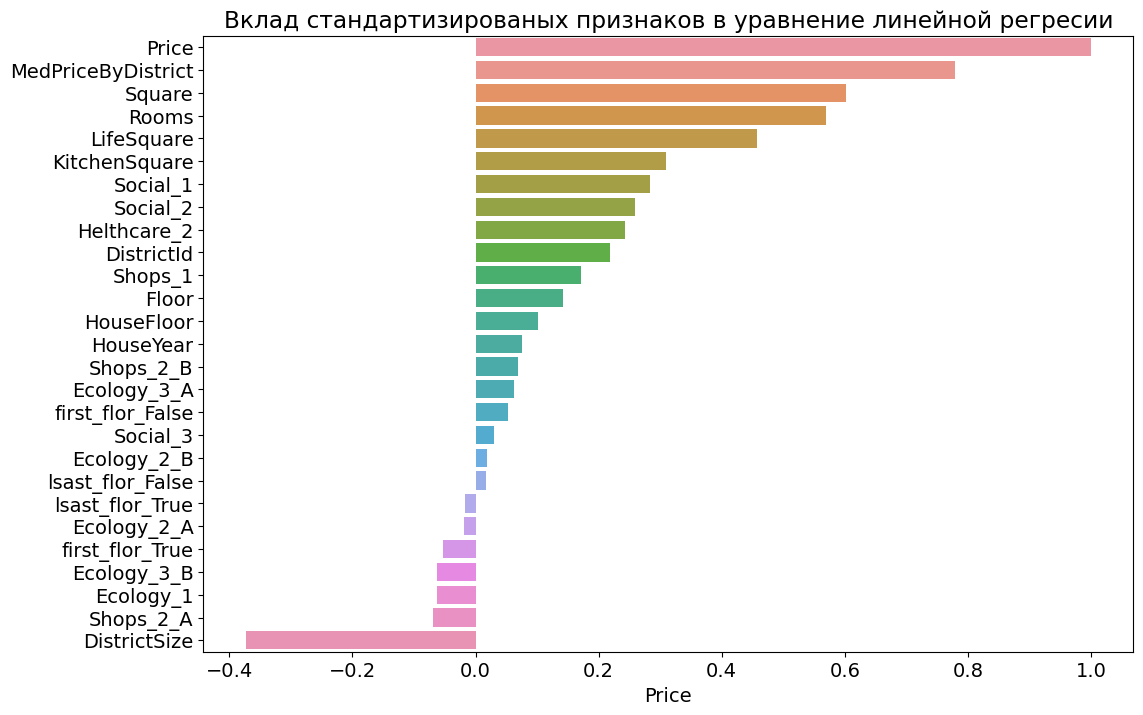

In [638]:
sc = StandardScaler()
df_std = sc.fit_transform(df) # что бы реально оценить вклад признака в уравнение прямой
df_std2 = pd.DataFrame(df_std, columns=df.columns).copy()
cor_matrix = df_std2.corr()
sorted_corr = cor_matrix['Price'].sort_values(ascending = False)
plt.figure(figsize=(12, 8))
sns.barplot(x=sorted_corr, y=sorted_corr.index)
plt.title('Вклад стандартизированых признаков в уравнение линейной регресии');

Числовые признаки LifeSquare, Rooms, Social 3, Social 2 отбросим они корелируют с другими признаками, но оказывают меньшее влияние на ицелевую переменную. 

## Автоматизация подачи данных

In [639]:
def load_data():
    DATASET_PATH = r'C:\Users\user\Desktop\DataScience\Libraries_for_DS\project\data\train.csv'
    return df
df = load_data()

In [640]:
def data_prepare_train(df, corr_threshhold=0.1):
    
    """Подготовка обучающего набора для обучения с отбрасывание
     части скадированных признаков за счет установки corr_threshhold
    
    """
    
    #замена пропусков
    df['LifeSquare'].fillna(df['Square']*0.6, inplace=True)
    
    if 'Healthcare_1' in df.columns:
            df.drop('Healthcare_1', axis=1, inplace=True)
            
            
    if 'Id' in df.columns:
            df.drop('Id', axis=1, inplace=True)

        
    ##   Добавление признаков    
    district_size = df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
    df = df.merge(district_size, on='DistrictId', how='left')   
    
    med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})
    df = df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
    
    # Удаление корелирующих признаков 
    del_col = ['LifeSquare', 'Rooms', 'Social_3', 'Social_2']
    df = df.drop(columns=del_col)

    # дампирование признаков
    cat_columns = df.select_dtypes(include=['category','bool','object']).columns
    df = pd.get_dummies(df, columns=cat_columns)
    
    
    sc=StandardScaler()
    df_std = sc.fit_transform(df) # что бы реально оценить вклад признака в уравнение прямой
    df_std2 = pd.DataFrame(df_std, columns=df.columns).copy()
    
    cor_matrix = df_std2.corr()
    sorted_corr = cor_matrix['Price'].sort_values(ascending = False)

    corr_dict = dict(sorted_corr)
    list_for_drop = []
    

    for k, v in corr_dict.items():
        if abs(v) < corr_threshhold:
            list_for_drop.append(k)     
        
    
    for el in list_for_drop:
        if el in df.columns:
            df.drop(columns=el, axis=1, inplace=True)
             
    drop_dict = {}       
    for k, v in corr_dict.items():
        if abs(v) < corr_threshhold:
            drop_dict[k] = v
            
    print(f' Удалены следующие признаки - {drop_dict}')  
    
    df = reduce_mem_usage(df)

    return df, list_for_drop

df, list_1 = data_prepare_train(df,corr_threshhold=0.1)

 Удалены следующие признаки - {'HouseYear': 0.07477217583407213, 'Shops_2_B': 0.06876773473341632, 'Ecology_3_A': 0.06253567247172864, 'first_flor_False': 0.05261136168134205, 'Ecology_2_B': 0.019304942101683913, 'lsast_flor_False': 0.01654379096600749, 'lsast_flor_True': -0.01654379096600749, 'Ecology_2_A': -0.01930494210168391, 'first_flor_True': -0.05261136168134205, 'Ecology_3_B': -0.06253567247172864, 'Ecology_1': -0.06269902130957929, 'Shops_2_A': -0.06876773473341632}
Memory usage of dataframe is 0.49 MB
Memory usage after optimization is: 0.38 MB
Decreased by 22.2%


## Разбиение на обучабщий и тестовый набор

In [641]:
def train_test_scaller(df):
    
    y = df['Price']
    X = df.drop(['Price'], axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, shuffle=True, random_state=97)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test

In [642]:
X_train, X_test, y_train, y_test = train_test_scaller(df)

## Функции для автоматического расчета метрик и визуализации обучения

In [643]:
def r2_adj(true_values, pred_values, X=df):
    r2_m = r2(true_values, pred_values)
    n = X.shape[0] # количество признаков
    k = X.shape[1] # количество параметров
    r2_adj = 1 - (1-r2_m)*((n-1)/(n-k))
    print(f'R2 Скоректированый:\t{round(r2_adj,3)}')

In [644]:
def evaluate_preds(true_values, pred_values, save=False, X=df):
    """Оценка качества модели и график preds vs true"""
    r2_m = r2(true_values, pred_values)
    n = X.shape[0] # количество признаков
    k = X.shape[1] # количество параметров
    r2_adj = 1 - (1-r2_m)*((n-1)/(n-k))
    
    print('R2:\t' + str(round(r2(true_values, pred_values), 5)) + '\n' +
          'R2adj:\t' + str(round(r2_adj,5))  + '\n' +
          'RMSE:\t' + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + '\n' +
          'MSE:\t' + str(round(mse(true_values, pred_values), 3)) +'\n' 
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

## Модель случайного леса для регрисионого анализа

R2:	0.74781
R2adj:	0.74749
RMSE:	44934.812
MSE:	2019137317.51



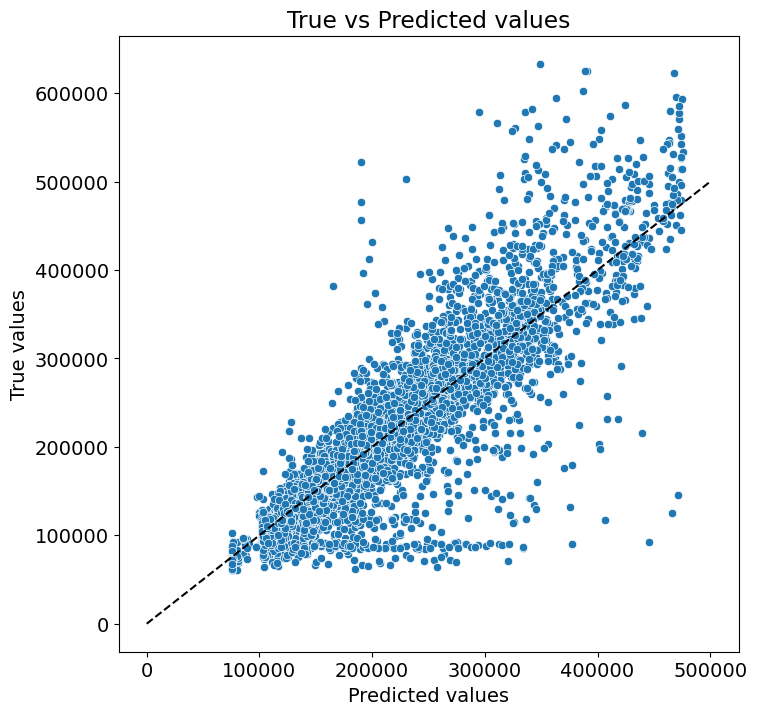

In [645]:
forest = RandomForestRegressor(criterion='mse',
                                 max_depth=30, # глубина дерева  
                                 min_samples_leaf=30, # минимальное кол-во наблюдений в листе дерева
                                 random_state=300,
                                 n_estimators=400  # кол-во деревьев
                                 )

forest.fit(X_train, y_train)
y_train_preds = forest.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.73204
R2adj:	0.7317
RMSE:	47414.218
MSE:	2248108098.659



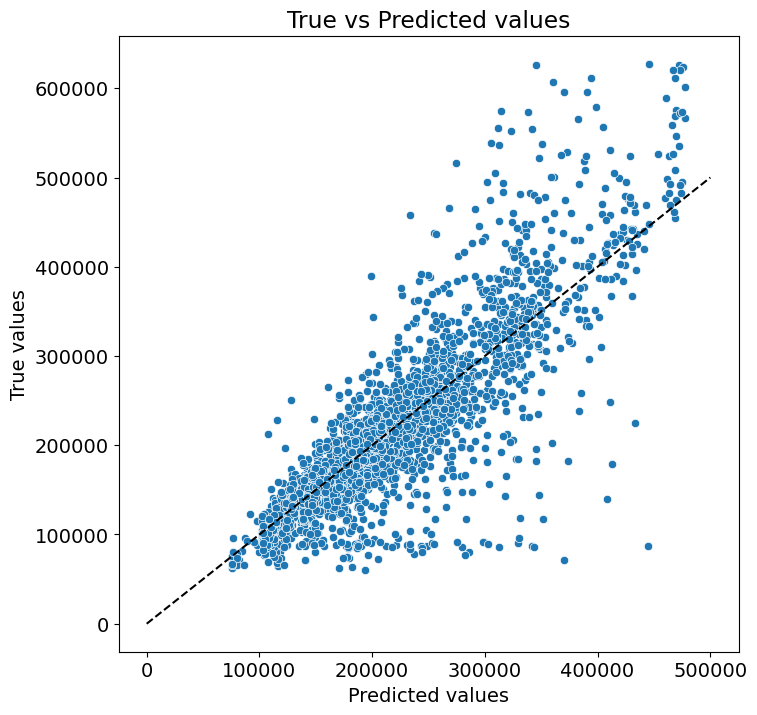

In [646]:
y_test_preds = forest.predict(X_test)
evaluate_preds(y_test, y_test_preds)

Лучшей моделью по метрике R2 оказался случайный лес.  

**R2: 0.72382 на обучающем наборе**  
**R2: 0.74223 на тесте**



### Выводы 
* Были добавлены новые признаки такие как Размер округа и Медианая цена по району, верхний и нижней этаж.  
Такие признаки как Размер округа и Медианая цена по району обладают существенной кореляцией с целеовй переменой 
* Часть признаков была отброшена если их вклад в кореляцию с целевой переменой меньше 0.1
* При сравнении 3 моделей (Линейная регресия, Лес, Случайный лес) с различными методами оптимизации был выбран алгоритм случайного леса со следующими гиперпараметрами 'max_depth': 30, 'min_samples_leaf': 30, 'n_estimators': 400
* Была осуществена замена вбросов медманными значениями исходя из значения целевой переменой +- 5%
* Мультиколинеарность между признаками была устранена. Признаки - 'LifeSquare', 'Rooms', 'Social_3', 'Social_2' вносящии меньший вклад в уравнение линейной регресии были отброшены.
* Наибольший вклад в уравнене прямой имеют такие признаки как площадь, а так же признак средней цены квартиры по району 